# 📈 Regime Discovery using Clustering (DBSCAN & KMeans)
This notebook replicates HMM-style regime discovery using unsupervised clustering methods.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import yfinance as yf

In [ ]:
def fetch_stock_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    return data.dropna()

In [ ]:
def create_features(returns):
    mean_returns = returns.mean(axis=1)
    std_returns = returns.std(axis=1)
    rolling_mean = returns.rolling(5).mean().mean(axis=1)
    rolling_std = returns.rolling(5).std().mean(axis=1)
    lower_quantile = returns.quantile(0.1, axis=1)
    upper_quantile = returns.quantile(0.9, axis=1)

    # Pairwise correlations
    correlations = []
    for i in returns.columns:
        for j in returns.columns:
            if i < j:
                corr = returns[i].rolling(10).corr(returns[j])
                correlations.append(corr)
    avg_correlation = pd.concat(correlations, axis=1).mean(axis=1)

    features = pd.DataFrame({
        'mean': mean_returns,
        'std': std_returns,
        'roll_mean': rolling_mean,
        'roll_std': rolling_std,
        'q10': lower_quantile,
        'q90': upper_quantile,
        'avg_corr': avg_correlation
    })

    return features.fillna(method='ffill').fillna(method='bfill')


In [44]:
def cluster_regimes(features):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)

    # KMeans clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled)

    # DBSCAN clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(scaled)

    features['kmeans_regime'] = kmeans_labels
    features['dbscan_regime'] = dbscan_labels

    return features, kmeans, dbscan


In [45]:
def plot_regimes(features, returns, method='kmeans_regime'):
    plt.figure(figsize=(15, 6))
    for regime in sorted(features[method].unique()):
        mask = features[method] == regime
        plt.plot(features.index[mask], returns.mean(axis=1)[mask], label=f'Regime {regime}')
    plt.title(f"Market Regimes ({method.upper()})")
    plt.xlabel("Date")
    plt.ylabel("Mean Return")
    plt.legend()
    plt.grid(True)
    plt.show()


[*********************100%***********************]  3 of 3 completed
/var/folders/54/4gpjnqfj49sgvzbjhxtjjz1w0000gn/T/ipykernel_12986/2676630969.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return features.fillna(method='ffill').fillna(method='bfill')
/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


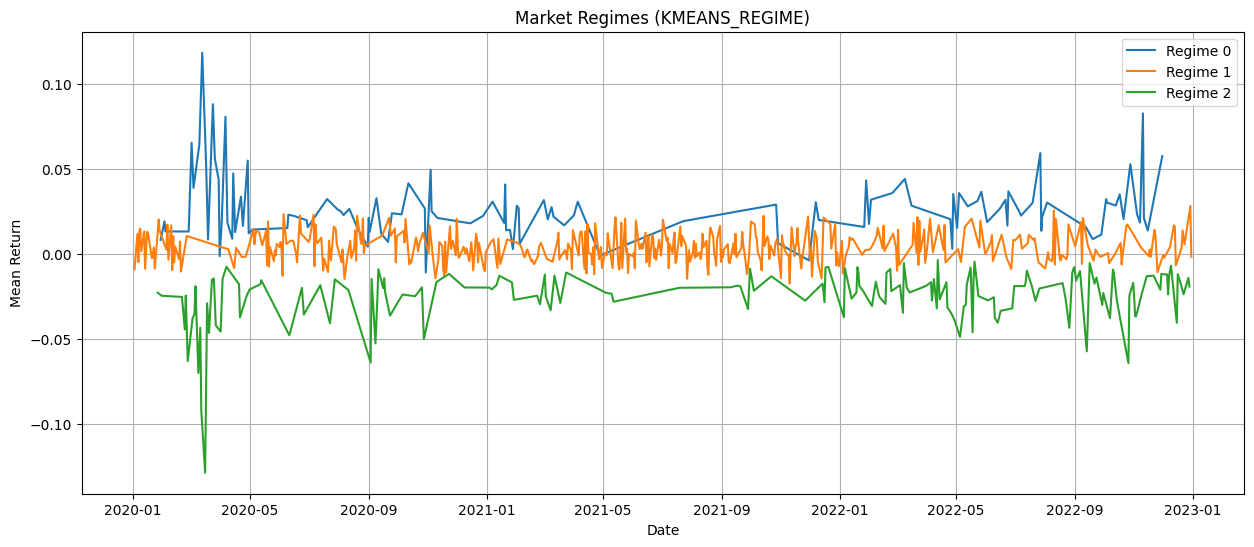

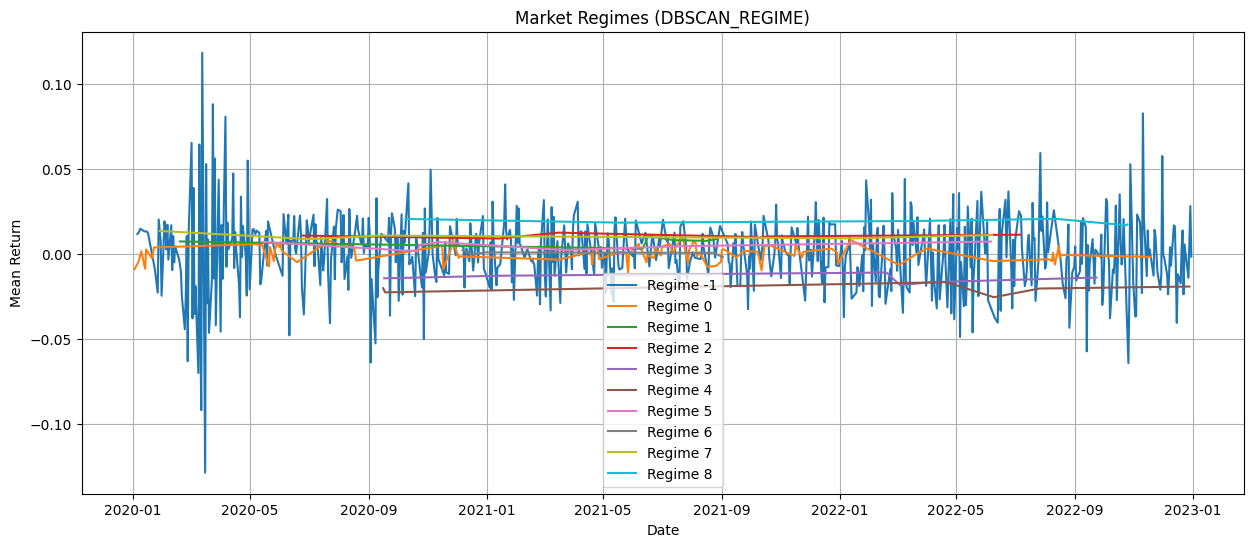

In [46]:
tickers = ["AAPL", "MSFT", "GOOG"]
start = "2020-01-01"
end = "2023-01-01"

prices_df = fetch_stock_data(tickers, start, end)
returns_df = prices_df.pct_change().dropna()
features_df = create_features(returns_df)

features_df, kmeans, dbscan = cluster_regimes(features_df)

# Plot
plot_regimes(features_df, returns_df, method='kmeans_regime')
plot_regimes(features_df, returns_df, method='dbscan_regime')


In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Drop cluster columns and scale features
X_scaled = StandardScaler().fit_transform(
    features_df.drop(columns=["kmeans_regime", "dbscan_regime"])
)

# Silhouette score for KMeans
kmeans_score = silhouette_score(X_scaled, features_df["kmeans_regime"])
print(f"📈 Silhouette Score (KMeans): {kmeans_score:.4f}")

# Silhouette score for DBSCAN
# DBSCAN includes -1 for "noise", which silhouette_score does not accept — remove those
valid_idx = features_df["dbscan_regime"] != -1
dbscan_score = silhouette_score(X_scaled[valid_idx], features_df["dbscan_regime"][valid_idx])
print(f"📉 Silhouette Score (DBSCAN, no noise): {dbscan_score:.4f}")

📈 Silhouette Score (KMeans): 0.2694
📉 Silhouette Score (DBSCAN, no noise): 0.1339


In [38]:

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def compare_clusterings(labels1, labels2, name1="Model 1", name2="Model 2"):
    print(f"Comparing {name1} vs {name2}")
    ari = adjusted_rand_score(labels1, labels2)
    nmi = normalized_mutual_info_score(labels1, labels2)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    print("-" * 40)
    return ari, nmi

# Prepare raw return features (unengineered)
raw_features = returns_df.copy().fillna(method='ffill').fillna(method='bfill')

# Scale
scaler = StandardScaler()
scaled_raw = scaler.fit_transform(raw_features)
scaled_feat = scaler.fit_transform(features_df.drop(columns=["kmeans_regime", "dbscan_regime"]))

# Train KMeans on both
kmeans_raw = KMeans(n_clusters=3, random_state=42).fit(scaled_raw)
kmeans_feat = KMeans(n_clusters=3, random_state=42).fit(scaled_feat)

# Train DBSCAN on both
dbscan_raw = DBSCAN(eps=1.0, min_samples=5).fit(scaled_raw)
dbscan_feat = DBSCAN(eps=1.0, min_samples=5).fit(scaled_feat)

# Compare metrics
compare_clusterings(kmeans_raw.labels_, kmeans_feat.labels_, "KMeans Raw", "KMeans Features")
compare_clusterings(dbscan_raw.labels_, dbscan_feat.labels_, "DBSCAN Raw", "DBSCAN Features")
compare_clusterings(kmeans_raw.labels_, dbscan_raw.labels_, "KMeans Raw", "DBSCAN Raw")
compare_clusterings(kmeans_feat.labels_, dbscan_feat.labels_, "KMeans Features", "DBSCAN Features")


Comparing KMeans Raw vs KMeans Features
Adjusted Rand Index (ARI): 0.4964
Normalized Mutual Information (NMI): 0.5025
----------------------------------------
Comparing DBSCAN Raw vs DBSCAN Features
Adjusted Rand Index (ARI): 0.1885
Normalized Mutual Information (NMI): 0.1669
----------------------------------------
Comparing KMeans Raw vs DBSCAN Raw
Adjusted Rand Index (ARI): 0.0257
Normalized Mutual Information (NMI): 0.0238
----------------------------------------
Comparing KMeans Features vs DBSCAN Features
Adjusted Rand Index (ARI): 0.2452
Normalized Mutual Information (NMI): 0.1511
----------------------------------------


/var/folders/54/4gpjnqfj49sgvzbjhxtjjz1w0000gn/T/ipykernel_12986/1754534061.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_features = returns_df.copy().fillna(method='ffill').fillna(method='bfill')
/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/nikita/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.24521912099457432, 0.15105585149524164)

High ARI or NMI scores (close to 1.0) mean the clusterings group data in very similar ways.
Low scores (near 0.0) suggest the models or features produce very different regime structures.

In [49]:

def calculate_regime_stats(returns_df, predicted_regimes):
    regimes = np.unique(predicted_regimes)
    stats = {}

    for regime in regimes:
        mask = predicted_regimes == regime
        regime_returns = returns_df.mean(axis=1)[mask]

        avg_return = regime_returns.mean() * 100
        volatility = regime_returns.std() * 100
        duration = mask.sum()

        transitions = np.sum(predicted_regimes[:-1] != predicted_regimes[1:])
        stability = (1 - transitions / len(predicted_regimes)) * 100

        label = "STABLE_BULL" if avg_return > 0 and volatility < 15 else \
                "VOLATILE_BULL" if avg_return > 0 else \
                "STABLE_BEAR" if volatility < 15 else "VOLATILE_BEAR"

        stats[regime] = {
            "label": label,
            "avg_return": avg_return,
            "volatility": volatility,
            "duration": duration,
            "stability": stability
        }

    return stats


In [50]:
def evaluate_regime_model(results_df, returns_df=None, regime_col='predicted_regime', true_col='true_regime'):
    print("=== Model Regime Evaluation ===")
    if returns_df is not None:
        test_returns = returns_df.loc[results_df.index]
        predicted_regimes = results_df[regime_col].values
        stats = calculate_regime_stats(test_returns, predicted_regimes)

        for regime, info in stats.items():
            print(f"🟨 {info['label']} Regime")
            print(f"  • Average Return: {info['avg_return']:.2f}%")
            print(f"  • Volatility: {info['volatility']:.2f}%")
            print(f"  • Duration: {info['duration']} days")
            print(f"  • Stability: {info['stability']:.2f}%\n")

        return stats

In [51]:
# Evaluate KMeans on Feature Engineered Data
evaluate_regime_model(
    pd.DataFrame({'predicted_regime': features_df['kmeans_regime']}, index=features_df.index),
    returns_df=returns_df
)


# Evaluate DBSCAN on Feature Engineered Data
evaluate_regime_model(
    pd.DataFrame({'predicted_regime': features_df['dbscan_regime']}, index=features_df.index),
    returns_df=returns_df
)

=== Model Regime Evaluation ===
🟨 STABLE_BULL Regime
  • Average Return: 2.70%
  • Volatility: 1.90%
  • Duration: 118 days
  • Stability: 55.23%

🟨 STABLE_BULL Regime
  • Average Return: 0.39%
  • Volatility: 0.88%
  • Duration: 461 days
  • Stability: 55.23%

🟨 STABLE_BEAR Regime
  • Average Return: -2.48%
  • Volatility: 1.57%
  • Duration: 176 days
  • Stability: 55.23%

=== Model Regime Evaluation ===
🟨 STABLE_BULL Regime
  • Average Return: 0.08%
  • Volatility: 2.25%
  • Duration: 618 days
  • Stability: 76.69%

🟨 STABLE_BULL Regime
  • Average Return: 0.02%
  • Volatility: 0.48%
  • Duration: 89 days
  • Stability: 76.69%

🟨 STABLE_BULL Regime
  • Average Return: 0.76%
  • Volatility: 0.25%
  • Duration: 6 days
  • Stability: 76.69%

🟨 STABLE_BULL Regime
  • Average Return: 1.05%
  • Volatility: 0.12%
  • Duration: 7 days
  • Stability: 76.69%

🟨 STABLE_BEAR Regime
  • Average Return: -1.45%
  • Volatility: 0.27%
  • Duration: 6 days
  • Stability: 76.69%

🟨 STABLE_BEAR Regime


{-1: {'label': 'STABLE_BULL',
  'avg_return': 0.07704896925948837,
  'volatility': 2.245248360547634,
  'duration': 618,
  'stability': 76.6887417218543},
 0: {'label': 'STABLE_BULL',
  'avg_return': 0.02191126696689762,
  'volatility': 0.4783226638061035,
  'duration': 89,
  'stability': 76.6887417218543},
 1: {'label': 'STABLE_BULL',
  'avg_return': 0.7612607782030297,
  'volatility': 0.24759850793745308,
  'duration': 6,
  'stability': 76.6887417218543},
 2: {'label': 'STABLE_BULL',
  'avg_return': 1.0515785833497362,
  'volatility': 0.11845312890070364,
  'duration': 7,
  'stability': 76.6887417218543},
 3: {'label': 'STABLE_BEAR',
  'avg_return': -1.4519513634032615,
  'volatility': 0.2652414738781031,
  'duration': 6,
  'stability': 76.6887417218543},
 4: {'label': 'STABLE_BEAR',
  'avg_return': -2.077842409194895,
  'volatility': 0.3018268207343415,
  'duration': 6,
  'stability': 76.6887417218543},
 5: {'label': 'STABLE_BULL',
  'avg_return': 0.5015693700249844,
  'volatility':